In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

%matplotlib inline

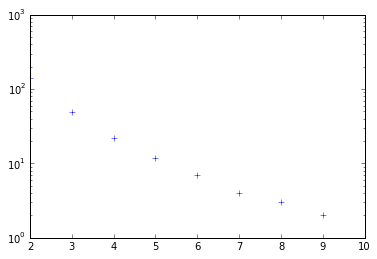

In [22]:
def nuProfile(Ntot,radii,k=-3.):
    nu0 = Ntot*k/((1+radii[-1])**(k+1)-1)
    return (nu0*((1+radii[1:])**(k+1)-(1+radii[:-1])**(k+1))/k).astype(int)

radii = np.linspace(1,10.,10)
plt.xscale('log')
plt.yscale('log')
plt.plot(radii[1:],nuProfile(1000,radii),'b+')
#plt.plot(np.power((1+np.linspace(0,10,10)),-3))

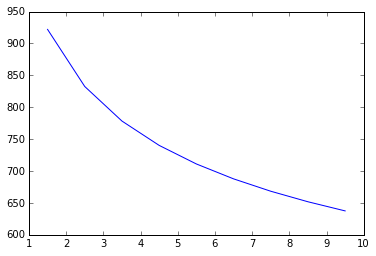

In [24]:
def sigmaProfile(radii,sigMax=1000,k=-.2):
    return sigMax*(0.5*(radii[1:]+radii[:-1]))**k

plt.plot(0.5*(radii[1:]+radii[:-1]),sigmaProfile(radii))

In [14]:
def createMockData(radii,Ntot=1000,sigMax=1000): #total Ngals, no of shells
    clusterData = np.zeros((Ntot,4))
    counter=0
    density = nuProfile(Ntot,radii,k=-3)
    sig = sigmaProfile(radii,sigMax=1000,k=-.2)
    
    for shell,dens in enumerate(density):
        #generate positions
        phi = np.random.uniform(0.,2*np.pi,dens)
        cosTheta = np.random.uniform(-1,1,dens)
        theta = np.arccos(cosTheta)
        u = np.random.uniform(radii[shell]**3,radii[shell+1]**3,dens) #cuberoot([rin,rout])
        r = np.power(u,1./3)
        
        x = r*np.sin(theta)*np.cos(phi)
        y = r*np.sin(theta)*np.sin(phi)
        z = r*cosTheta
        
        #generate velocities
        
        speed = sig[shell]*np.random.randn(dens)
        #phi = np.random.uniform(0.,2*np.pi,dens)
        cosTheta = np.random.uniform(-1,1,dens)
        #theta = np.arccos(cosTheta)
        
        v=speed*cosTheta   
        
        #replace with vstack,append
        clusterData[counter:counter+dens,:]=np.hstack((shell.reshape((dens,1)),x.reshape((dens,1)),y.reshape((dens,1)),z.reshape((dens,1)),v.reshape((dens,1))))
        counter += dens
    
    return clusterData

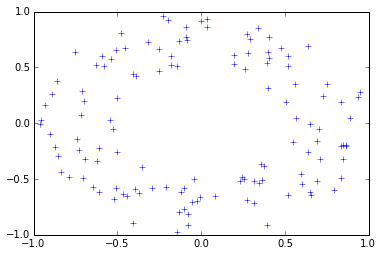

In [15]:
shell = createMockData(1000)

plt.plot(shell[np.where(np.fabs(shell[:,2])<0.1)][:,0],shell[np.where(np.fabs(shell[:,2])<0.1)
                                                             ][:,1],'b+')

In [11]:
0.5**(3)

0.125